In [1]:
import pandas as pd
# pandas 소수점 3자리
pd.options.display.precision = 3
import numpy as np
from sklearn.model_selection import train_test_split

# 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz

# 시계열
from fbprophet import Prophet 
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly
import plotly.offline as py
import plotly.graph_objs as go

import copy
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

In [2]:
# 한글 깨짐 해결 : unicode minus를 사용하지 않기 위한 설정(minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False

# 0. 한글 폰트 적용(나눔 고딕)
from matplotlib import font_manager as fm
matplotlib.rc("font", family="NanumGothic")
fm._rebuild()

In [3]:
# 0. 나무 시각화 패키지 설치
# os 환경
import os
# PATH 설정 : graphviz 설치된 경로 지정. 기본 경로는 아래 참고(linux에서 설치된 경로 확인 및 변경 필요)
os.environ["PATH"] += os.pathsep + "/home/piai/anaconda3/lib/python3.8/site-packages/graphviz"

### 데이터 불러오기

In [4]:
# 1. 데이터 구성하기
df_mem = pd.read_csv("jeju_member.csv", engine = "python", encoding='UTF-8')
df_mem.head()

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,taltoi_date,member_month,gaip_path,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong,ri,address
0,C102666,1976-11-08,남,44,40대,일반,3Gold,2014-10-07,NaN,63,매장,Y,Y,Y,Y,690-170,제주시,연동,NaN,제주 제주시 연동
1,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,기타,Y,Y,Y,Y,690-122,제주시,아라2동,NaN,제주 제주시 아라2동
2,C118133,1981-03-20,남,39,30대,일반,4Silver,2011-12-07,2014-04-02,28,매장,N,Y,Y,N,699-900,서귀포시,성산읍,NaN,제주 서귀포시 성산읍
3,C118278,1979-06-22,여,41,40대,일반,3Gold,2011-12-11,NaN,97,인터넷,Y,Y,Y,Y,695-791,제주시,애월읍,광령2리,제주 제주시 애월읍 광령2리 제주관광대학
4,C118280,1959-08-28,남,61,60대,일반,3Gold,2011-12-11,2016-05-02,53,기타,N,N,N,N,699-905,서귀포시,성산읍,삼달리,제주 서귀포시 성산읍 삼달리


In [5]:
df_mem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6013 non-null   object
 1   birth_date      6013 non-null   object
 2   gender          6013 non-null   object
 3   age             6013 non-null   int64 
 4   agegroup        6013 non-null   object
 5   customer_type   6013 non-null   object
 6   customer_grade  6013 non-null   object
 7   gaip_date       6013 non-null   object
 8   taltoi_date     634 non-null    object
 9   member_month    6013 non-null   int64 
 10  gaip_path       6013 non-null   object
 11  flag_member     6013 non-null   object
 12  flag_rcv_sms    6013 non-null   object
 13  flag_rcv_email  6013 non-null   object
 14  flag_rcv_post   6013 non-null   object
 15  zipcode         6013 non-null   object
 16  sigun           6013 non-null   object
 17  dong            6013 non-null   object
 18  ri      

In [6]:
df_mem.isnull().sum()

customer_id          0
birth_date           0
gender               0
age                  0
agegroup             0
customer_type        0
customer_grade       0
gaip_date            0
taltoi_date       5379
member_month         0
gaip_path            0
flag_member          0
flag_rcv_sms         0
flag_rcv_email       0
flag_rcv_post        0
zipcode              0
sigun                0
dong                 0
ri                3570
address              0
dtype: int64

- 탈퇴일자는 flag_member로 대체 가능
- 리는 주소로 대체 가능

In [7]:
# 1. 데이터 구성하기
df_sales = pd.read_csv("jeju_sales.csv", engine = "python", encoding='UTF-8')
df_sales.head()

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt
0,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P08010117,간식,과자,스낵,꼬마찹쌀모나카(112g/8개),1,3000,3000
1,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040101,양념/가루,장,간장,제주전통어간장(500ml),1,7900,7900
2,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040100,양념/가루,장,간장,맛간장(900ml),1,13600,13600
3,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010305,양념/가루,가루,곡식가루,엿기름가루(무/500g),2,3200,6400
4,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010301,양념/가루,가루,곡식가루,메주가루(500g),2,11000,22000


In [8]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273322 entries, 0 to 273321
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   customer_id         273322 non-null  object
 1   purchase_id         273322 non-null  object
 2   store_id            273322 non-null  object
 3   purchase_yearmonth  273322 non-null  object
 4   purchase_weekday    273322 non-null  object
 5   purchase_hour       273322 non-null  int64 
 6   purchase_date       273322 non-null  object
 7   purchase_time       273322 non-null  object
 8   supply_date         273322 non-null  object
 9   item_id             273322 non-null  object
 10  item_g_l            273322 non-null  object
 11  item_g_m            273322 non-null  object
 12  item_g_s            273322 non-null  object
 13  item_name           273322 non-null  object
 14  purchase_cnt        273322 non-null  int64 
 15  unit_cost           273322 non-null  int64 
 16  pu

In [9]:
df_sales.isnull().sum()

customer_id           0
purchase_id           0
store_id              0
purchase_yearmonth    0
purchase_weekday      0
purchase_hour         0
purchase_date         0
purchase_time         0
supply_date           0
item_id               0
item_g_l              0
item_g_m              0
item_g_s              0
item_name             0
purchase_cnt          0
unit_cost             0
purchase_amt          0
dtype: int64

In [10]:
# 1. 데이터 구성하기
df_zip = pd.read_csv("jeju_zipcode.csv", engine = "python", encoding='CP949')
df_zip.head()

,zipcode,address
0,697-370,\t제주 서귀포시 강정동
1,697-826,\t제주 서귀포시 강정동 1~199
2,697-828,\t제주 서귀포시 강정동 1000~4099
3,697-827,\t제주 서귀포시 강정동 200~999
4,697-829,\t제주 서귀포시 강정동 4100~6000


In [11]:
df_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   zipcode  372 non-null    object
 1   address  372 non-null    object
dtypes: object(2)
memory usage: 5.9+ KB


### 데이터 정제

#### df_mem

In [12]:
# taltoi_date, ri, address drop
df_mem = df_mem.drop(["taltoi_date","ri", "address"], axis=1, inplace=False)
df_mem.head()

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,member_month,gaip_path,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong
0,C102666,1976-11-08,남,44,40대,일반,3Gold,2014-10-07,63,매장,Y,Y,Y,Y,690-170,제주시,연동
1,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,97,기타,Y,Y,Y,Y,690-122,제주시,아라2동
2,C118133,1981-03-20,남,39,30대,일반,4Silver,2011-12-07,28,매장,N,Y,Y,N,699-900,서귀포시,성산읍
3,C118278,1979-06-22,여,41,40대,일반,3Gold,2011-12-11,97,인터넷,Y,Y,Y,Y,695-791,제주시,애월읍
4,C118280,1959-08-28,남,61,60대,일반,3Gold,2011-12-11,53,기타,N,N,N,N,699-905,서귀포시,성산읍


- 탈퇴일자는 flag_member로 대체 가능
- 리는 주소는 너무 자세한 내용이고 대부분 다 다르기 때문에 제거

In [13]:
df_mem.isnull().sum()

customer_id       0
birth_date        0
gender            0
age               0
agegroup          0
customer_type     0
customer_grade    0
gaip_date         0
member_month      0
gaip_path         0
flag_member       0
flag_rcv_sms      0
flag_rcv_email    0
flag_rcv_post     0
zipcode           0
sigun             0
dong              0
dtype: int64

#### df_sales

In [14]:
# unit_cost 가격을 2018년도 가격으로 맞추기
df_sales.loc[(df_sales["item_name"]=='미니단호박(무/800g이상/2~3개)-제주' )&(df_sales["unit_cost"]==0 ), 'unit_cost'] = 4500

df_sales[(df_sales["item_name"]=='미니단호박(무/800g이상/2~3개)-제주' ) & (df_sales["purchase_id"]=='C463546_20180713_38')]

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt
130296,C463546,C463546_20180713_38,제주매장,2018M07,금요일,12,2018-07-13,:0:12:31:43,2018-07-13,P05021002,채소,열매채소,미니단호박,미니단호박(무/800g이상/2~3개)-제주,1,4500,0


In [15]:
# purchase_cnt = 0 -> 분석에서 제외
idx = df_sales.loc[df_sales['purchase_cnt']==0, ].index
df_sales = df_sales.drop(idx)

In [16]:
# purchase_amt 이상치 처리 => amt 재계산
df_amt = df_sales
df_amt.loc[df_amt['purchase_cnt']!=0, 'purchase_amt'] = (df_amt['purchase_cnt']*df_amt['unit_cost'])

df_sales = df_amt
df_sales

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt
0,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P08010117,간식,과자,스낵,꼬마찹쌀모나카(112g/8개),1,3000,3000
1,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040101,양념/가루,장,간장,제주전통어간장(500ml),1,7900,7900
2,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040100,양념/가루,장,간장,맛간장(900ml),1,13600,13600
3,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010305,양념/가루,가루,곡식가루,엿기름가루(무/500g),2,3200,6400
4,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010301,양념/가루,가루,곡식가루,메주가루(500g),2,11000,22000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273317,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P01010104,주곡,멥쌀,백미,백미/유(4kg)-매장용,1,15700,15700
273318,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P08010301,간식,과자,한과/유과,차례상약과(350g/10개),1,8800,8800
273319,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P06040300,축산물,유제품,아이스크림,유기농아이스크림(기본형),1,8900,8900
273320,C705016,C705016_20191229_51,서귀포매장,2019M12,일요일,14,2019-12-29,:0:14:53:30,2019-12-29,P08040137,간식,빵,빵,쌀로만든잉글리쉬머핀(66g×4개)/매장,1,3900,3900


In [17]:
# cnt < 6 인 자료들만 갖고 진행
# 한번에 대량구매하는 이상치를 막기 위해
df_sales = df_sales[(df_sales["purchase_cnt"] < 6)]
df_sales

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt
0,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P08010117,간식,과자,스낵,꼬마찹쌀모나카(112g/8개),1,3000,3000
1,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040101,양념/가루,장,간장,제주전통어간장(500ml),1,7900,7900
2,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040100,양념/가루,장,간장,맛간장(900ml),1,13600,13600
3,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010305,양념/가루,가루,곡식가루,엿기름가루(무/500g),2,3200,6400
4,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010301,양념/가루,가루,곡식가루,메주가루(500g),2,11000,22000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273317,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P01010104,주곡,멥쌀,백미,백미/유(4kg)-매장용,1,15700,15700
273318,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P08010301,간식,과자,한과/유과,차례상약과(350g/10개),1,8800,8800
273319,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P06040300,축산물,유제품,아이스크림,유기농아이스크림(기본형),1,8900,8900
273320,C705016,C705016_20191229_51,서귀포매장,2019M12,일요일,14,2019-12-29,:0:14:53:30,2019-12-29,P08040137,간식,빵,빵,쌀로만든잉글리쉬머핀(66g×4개)/매장,1,3900,3900


In [18]:
# df_mem, df_sales 합치기
df_memsales = pd.merge(df_sales, df_mem, on=['customer_id'], how='left')
df_memsales

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,...,gaip_date,member_month,gaip_path,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong
0,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P08010117,...,2011-12-06,97,기타,Y,Y,Y,Y,690-122,제주시,아라2동
1,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040101,...,2011-12-06,97,기타,Y,Y,Y,Y,690-122,제주시,아라2동
2,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040100,...,2011-12-06,97,기타,Y,Y,Y,Y,690-122,제주시,아라2동
3,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010305,...,2011-12-06,97,기타,Y,Y,Y,Y,690-122,제주시,아라2동
4,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010301,...,2011-12-06,97,기타,Y,Y,Y,Y,690-122,제주시,아라2동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271017,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P01010104,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍
271018,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P08010301,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍
271019,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P06040300,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍
271020,C705016,C705016_20191229_51,서귀포매장,2019M12,일요일,14,2019-12-29,:0:14:53:30,2019-12-29,P08040137,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍


### 탐색적 분석

In [19]:
# 최근 세 달만 있는 데이터 추출
df_msales = df_memsales[df_memsales['purchase_date']>='2019-10-01']

df_msales

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,...,gaip_date,member_month,gaip_path,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong
101,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P09040503,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
102,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P05070600,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
103,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P10020105,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
104,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P05041700,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
105,C118291,C118291_20191024_78,제주매장,2019M10,목요일,16,2019-10-24,:0:16:11:47,2019-10-24,P09010102,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271017,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P01010104,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍
271018,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P08010301,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍
271019,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P06040300,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍
271020,C705016,C705016_20191229_51,서귀포매장,2019M12,일요일,14,2019-12-29,:0:14:53:30,2019-12-29,P08040137,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍


#### 최근 3달 동안 나이대별 분포 및 객단가

1. 최근 3달 동안 나이대별 분포

agegroup
20대       30
30대     4695
40대    10226
50대     6896
60대     3667
70대      628
80대      232
dtype: int64


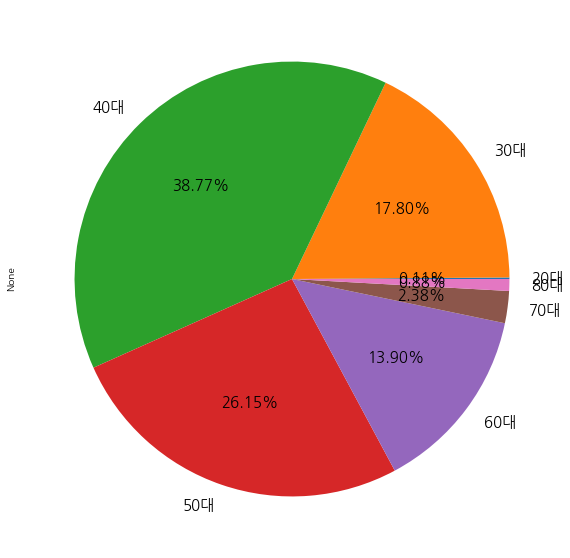

In [20]:
df_memsales_purchaseamt_age = df_msales.groupby(['agegroup']).size()
df_memsales_purchaseamt_age.plot(figsize=(20,10),kind = "pie",autopct = "%.2f%%", fontsize = 15)
print(df_memsales_purchaseamt_age)

2. 최근 3달 동안 나이대별 객단가

In [21]:
df_age_객단가 = df_msales.groupby(['purchase_id','agegroup']).sum()
df_age_객단가

,,purchase_hour,purchase_cnt,unit_cost,purchase_amt,age,member_month
purchase_id,agegroup,,,,,,
C118291_20191010_142,50대,64,4,20700,20700,232,388
C118291_20191024_78,50대,112,7,31500,31500,406,679
C118291_20191104_15,50대,55,5,21700,21700,290,485
C118291_20191113_169,50대,68,4,12600,12600,232,388
C118291_20191115_124,50대,16,1,10900,10900,58,97
...,...,...,...,...,...,...,...
C704271_20191220_139,40대,17,1,6500,6500,48,1
C704271_20191221_57,40대,39,3,7900,7900,144,3
C704612_20191220_35,50대,11,4,2700,10800,51,1


  agegroup  purchase_amt
0      20대      8100.000
1      30대     15426.970
2      40대     16371.504
3      50대     17914.545
4      60대     18410.217
5      70대     15259.122
6      80대     15766.795


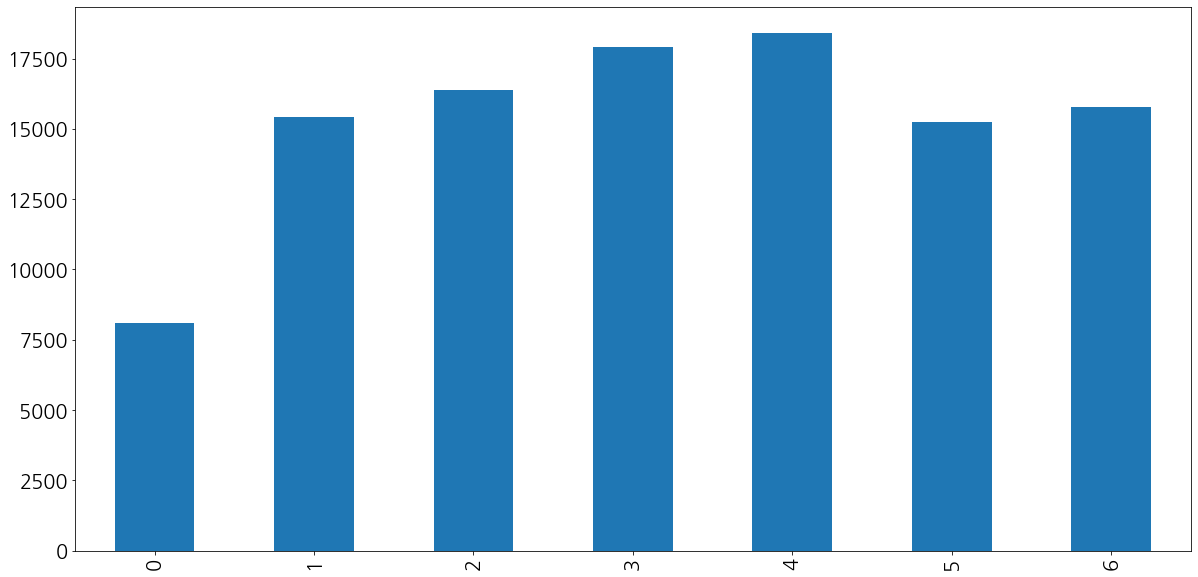

In [22]:
df_memsales_purchaseamt_agegroup = df_age_객단가.groupby(['agegroup'])['purchase_amt'].mean().reset_index()
df_memsales_purchaseamt_agegroup['purchase_amt'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_memsales_purchaseamt_agegroup)

#### 최근 3달 동안 성별 분포 및 객단가

1. 최근 3달 동안 성별 분포

gender
남     2945
여    23429
dtype: int64


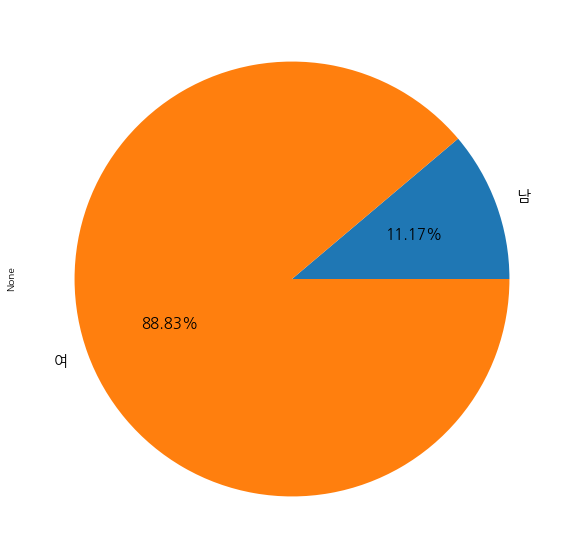

In [23]:
df_memsales_purchaseamt_gender = df_msales.groupby(['gender']).size()
df_memsales_purchaseamt_gender.plot(figsize=(20,10),kind = "pie",autopct = "%.2f%%", fontsize = 15)
print(df_memsales_purchaseamt_gender)

2. 최근 3달 동안 성별 객단가

In [24]:
df_gender_객단가 = df_msales.groupby(['purchase_id','gender']).sum()
df_gender_객단가

,,purchase_hour,purchase_cnt,unit_cost,purchase_amt,age,member_month
purchase_id,gender,,,,,,
C118291_20191010_142,여,64,4,20700,20700,232,388
C118291_20191024_78,여,112,7,31500,31500,406,679
C118291_20191104_15,여,55,5,21700,21700,290,485
C118291_20191113_169,여,68,4,12600,12600,232,388
C118291_20191115_124,여,16,1,10900,10900,58,97
...,...,...,...,...,...,...,...
C704271_20191220_139,여,17,1,6500,6500,48,1
C704271_20191221_57,여,39,3,7900,7900,144,3
C704612_20191220_35,여,11,4,2700,10800,51,1


  gender  purchase_amt
0      남     21095.835
1      여     16356.689


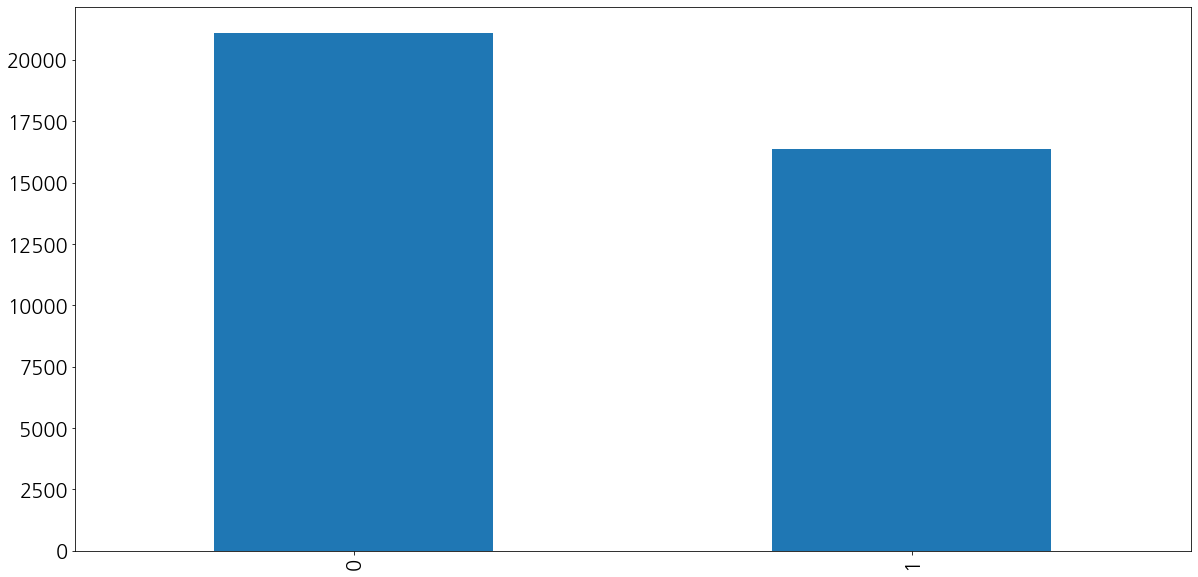

In [25]:
df_memsales_purchaseamt_gender = df_gender_객단가.groupby(['gender'])['purchase_amt'].mean().reset_index()
df_memsales_purchaseamt_gender['purchase_amt'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_memsales_purchaseamt_gender)

#### 최근 3달 동안 시간대별 온라인, 오프라인 매출 총액

1. 최근 3달 동안 오프라인 매출 총액

In [26]:
df_msales_js = df_msales[(df_msales["store_id"] == '제주매장') | (df_msales["store_id"] == '서귀포매장')]
df_msales_js

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,...,gaip_date,member_month,gaip_path,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong
101,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P09040503,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
102,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P05070600,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
103,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P10020105,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
104,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P05041700,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
105,C118291,C118291_20191024_78,제주매장,2019M10,목요일,16,2019-10-24,:0:16:11:47,2019-10-24,P09010102,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271017,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P01010104,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍
271018,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P08010301,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍
271019,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P06040300,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍
271020,C705016,C705016_20191229_51,서귀포매장,2019M12,일요일,14,2019-12-29,:0:14:53:30,2019-12-29,P08040137,...,2019-12-04,1,인터넷,Y,Y,N,Y,699-900,서귀포시,성산읍


    purchase_hour  purchase_amt
0               9         99850
1              10       8618288
2              11      13667943
3              12      11860706
4              13      11839906
5              14      11858540
6              15      12513579
7              16      18335270
8              17      14484103
9              18      13078286
10             19       9456345
11             20        312125


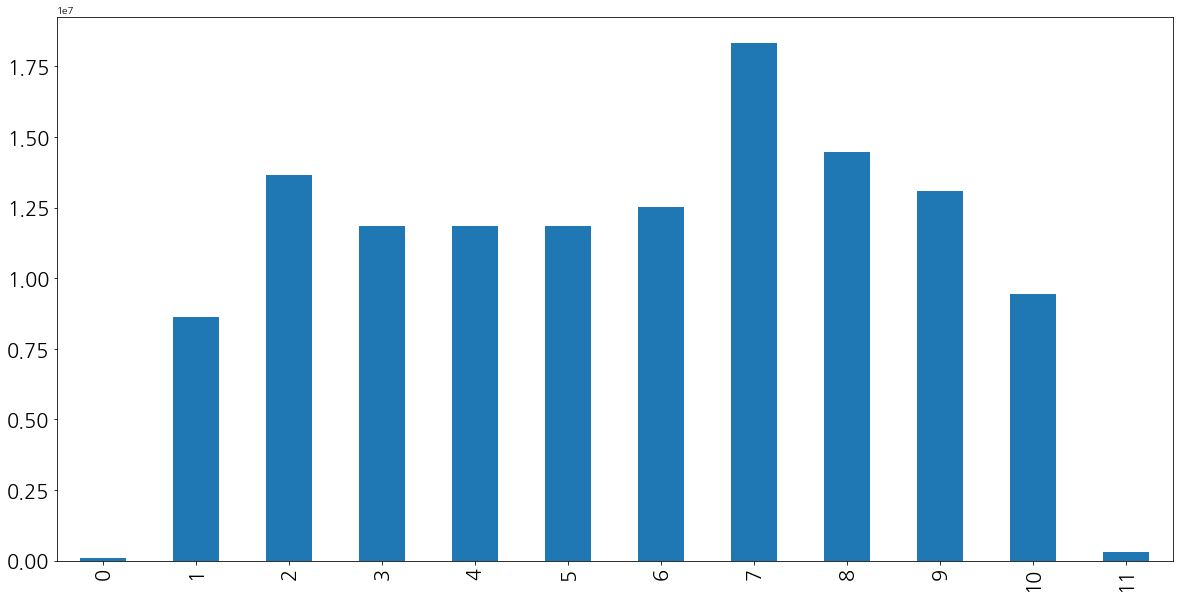

In [27]:
df_memsales_purchaseamt_customergrade = df_msales_js.groupby(['purchase_hour'])['purchase_amt'].sum().reset_index()
df_memsales_purchaseamt_customergrade['purchase_amt'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_memsales_purchaseamt_customergrade)

2. 최근 3달 동안 온라인 매출 총액

In [28]:
df_msales_im = df_msales[(df_msales["store_id"] == '인터넷') | (df_msales["store_id"] == '모바일')]
df_msales_im

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,...,gaip_date,member_month,gaip_path,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong
2118,C121449,C121449_20191006_100,모바일,2019M10,일요일,22,2019-10-06,:0:22:40:36,2019-10-10,P10030200,...,2012-01-23,96,인터넷,Y,Y,Y,Y,690-802,제주시,노형동
2119,C121449,C121449_20191006_100,모바일,2019M10,일요일,22,2019-10-06,:0:22:40:36,2019-10-10,P10030500,...,2012-01-23,96,인터넷,Y,Y,Y,Y,690-802,제주시,노형동
2120,C121449,C121449_20191006_100,모바일,2019M10,일요일,22,2019-10-06,:0:22:40:36,2019-10-10,P01010103,...,2012-01-23,96,인터넷,Y,Y,Y,Y,690-802,제주시,노형동
2121,C121449,C121449_20191006_100,모바일,2019M10,일요일,22,2019-10-06,:0:22:40:36,2019-10-10,P05013500,...,2012-01-23,96,인터넷,Y,Y,Y,Y,690-802,제주시,노형동
2122,C121449,C121449_20191006_100,모바일,2019M10,일요일,22,2019-10-06,:0:22:40:36,2019-10-10,P06040200,...,2012-01-23,96,인터넷,Y,Y,Y,Y,690-802,제주시,노형동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270950,C701974,C701974_20191226_100,인터넷,2019M12,목요일,22,2019-12-26,:0:22:13:25,2020-01-08,P05081600,...,2019-11-19,2,전화,Y,Y,Y,Y,690-150,제주시,오등동
270951,C701974,C701974_20191226_100,인터넷,2019M12,목요일,22,2019-12-26,:0:22:13:25,2020-01-08,P05081400,...,2019-11-19,2,전화,Y,Y,Y,Y,690-150,제주시,오등동
270952,C701974,C701974_20191226_100,인터넷,2019M12,목요일,22,2019-12-26,:0:22:13:25,2020-01-08,P05017500,...,2019-11-19,2,전화,Y,Y,Y,Y,690-150,제주시,오등동
270953,C701974,C701974_20191226_100,인터넷,2019M12,목요일,22,2019-12-26,:0:22:13:25,2020-01-08,P05015300,...,2019-11-19,2,전화,Y,Y,Y,Y,690-150,제주시,오등동


    purchase_hour  purchase_amt
0               0        102250
1               1         54300
2               2         61050
3               3         24450
4               5         43800
5               6         18850
6               7        243430
7               8        316050
8               9        627600
9              10        601750
10             11        824950
11             12        581900
12             13        912250
13             14       1112630
14             15       1141480
15             16        707300
16             17        542150
17             18        955000
18             19       1161350
19             20        994530
20             21        490280
21             22        592650
22             23        373850


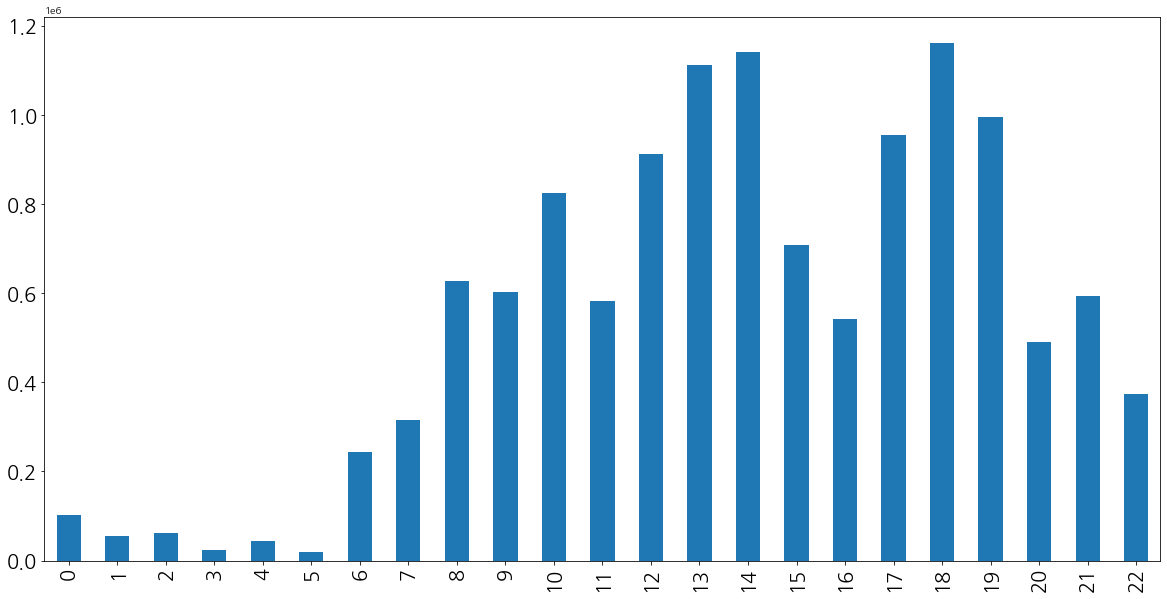

In [29]:
df_memsales_purchaseamt_customergrade = df_msales_im.groupby(['purchase_hour'])['purchase_amt'].sum().reset_index()
df_memsales_purchaseamt_customergrade['purchase_amt'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_memsales_purchaseamt_customergrade)

3. 구매경로 매출액 파이차트

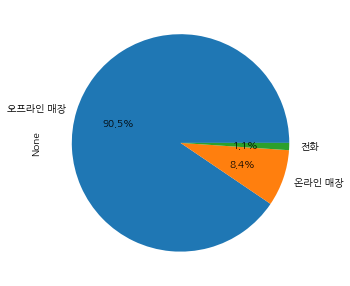

In [30]:
tmp = copy.deepcopy(df_msales[['store_id', 'purchase_id', 'purchase_amt']])

tmp.loc[(tmp["store_id"] == '제주매장') \
         | (tmp["store_id"] == '서귀포매장'), 'store'] = "오프라인 매장"
tmp.loc[(tmp["store_id"] == '인터넷') \
         | (tmp["store_id"] == '모바일'), 'store'] = "온라인 매장"  
tmp.loc[(tmp["store_id"] == '전화') \
         | (tmp["store_id"] == '전화'), 'store'] = "전화"  

g_cnt = tmp.groupby(["store"]).size()
g_cnt.plot.pie(y="store", autopct="%.1f%%",figsize=(10,5))

#### Prophet을 이용한 시계열 분석을 통해 매출액 및 객단가 추세 파악(월별)

1. 월별 매출액 시계열

<ipython-input-31-c8ae8c4c201c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


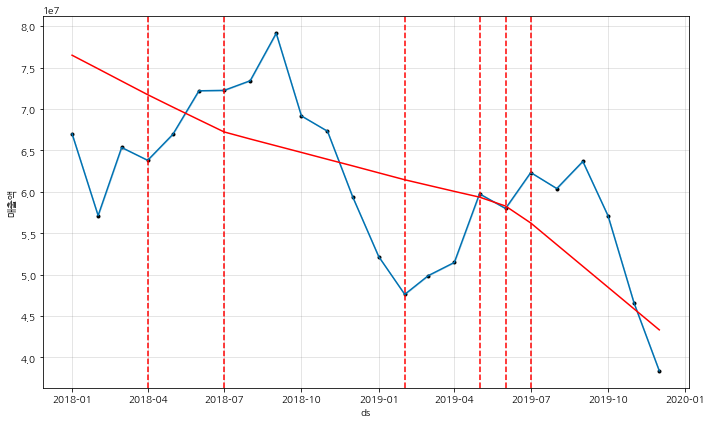

In [31]:
df_store = df_sales[['purchase_yearmonth', 'store_id', 'purchase_amt']]

df_store['purchase_yearmonth'] = pd.to_datetime(df_store['purchase_yearmonth'], format='%YM%m', errors='raise')
df_store = df_store.groupby(['purchase_yearmonth'])['purchase_amt'].sum().reset_index()
df_store = df_store.rename({'purchase_yearmonth':'ds', 'purchase_amt':'y'}, axis='columns')
    
    
m = Prophet(
        # trend
    changepoint_prior_scale=0.05,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=10,
    daily_seasonality=False,
    #     seasonality_mode='multiplicative',
)

m.fit(df_store)

future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)

fig1 = m.plot(forecast, ylabel='매출액')
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

2. 월별 객단가 시계열

In [32]:
df_memsales_객단가 = df_sales.groupby(['purchase_id', 'purchase_yearmonth'])['purchase_amt'].sum().reset_index()
df_memsales_purchaseamt_month = df_memsales_객단가.groupby(['purchase_yearmonth'])['purchase_amt'].mean().reset_index()
df_memsales_purchaseamt_month

,purchase_yearmonth,purchase_amt
0,2018M01,26758.866
1,2018M02,25168.524
2,2018M03,24430.292
3,2018M04,25328.896
4,2018M05,25416.325
5,2018M06,25941.444
6,2018M07,24801.940
7,2018M08,23371.210
8,2018M09,25260.741
9,2018M10,25371.411


INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


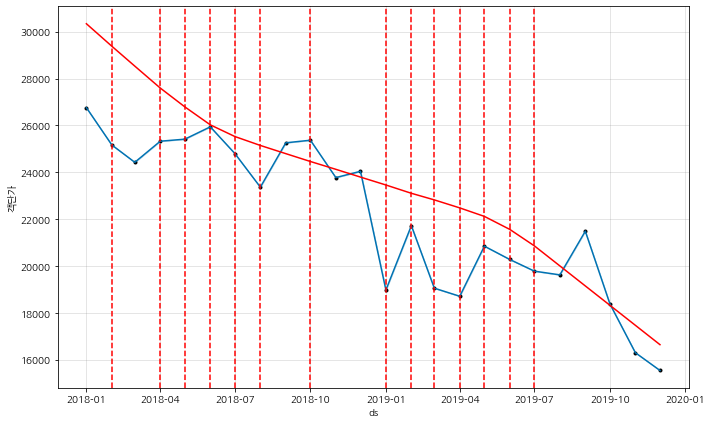

In [33]:
df_memsales_purchaseamt_month['purchase_yearmonth'] = pd.to_datetime(df_memsales_purchaseamt_month['purchase_yearmonth'], format='%YM%m', errors='raise')
df_item = df_memsales_purchaseamt_month.rename({'purchase_yearmonth':'ds', 'purchase_amt':'y'}, axis='columns')
 

m = Prophet(
        # trend
    changepoint_prior_scale=0.05,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=10,
    daily_seasonality=False,
    #     seasonality_mode='multiplicative',
)

m.fit(df_item)

future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)

fig1 = m.plot(forecast, ylabel="객단가")
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

#### Trend 차트를 통해 매출 추세 파악

In [34]:
# 각 월별 분류 판매 총액 비교 그래프
d_m = df_sales.groupby(['item_g_m', 'purchase_yearmonth'])['purchase_amt'].sum().reset_index()

d_m['purchase_yearmonth'] = pd.to_datetime(d_m['purchase_yearmonth'], format='%YM%m', errors='raise')
# [datetime.strptime(x, '%Y-%m-%d') for x in d_c['purchase_date']]
# datetime.strptime(d_c['purchase_date'], '%Y-%m-%d')
# purchase_time으로 하면 이상하게 나옴 세로로 그려짐
d_m

,item_g_m,purchase_yearmonth,purchase_amt
0,가루,2018-01-01,3444400
1,가루,2018-02-01,2544570
2,가루,2018-03-01,2940300
3,가루,2018-04-01,3084800
4,가루,2018-05-01,2214300
...,...,...,...
847,한우,2019-08-01,2888225
848,한우,2019-09-01,3980160
849,한우,2019-10-01,3148755
850,한우,2019-11-01,2524240


In [35]:
d_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   item_g_m            852 non-null    object        
 1   purchase_yearmonth  852 non-null    datetime64[ns]
 2   purchase_amt        852 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 20.1+ KB


In [36]:
d_m_pivot = d_m.pivot(index = "purchase_yearmonth", columns = "item_g_m", values = "purchase_amt")
d_m_pivot.head(24)

item_g_m,가루,과일채소,과자,기름/식초,김장채소,김치,꿀,닭,돼지,두부/유부,...,육가공,잎/줄기채소,잎채소,장,잼/병조림/기타,절임/장아찌,즉석조리,찹쌀,특용작물,한우
purchase_yearmonth,,,,,,,,,,,,,,,,,,,,,
2018-01-01,3.444e+06,1.668e+06,5.747e+06,3.353e+06,NaN,4.573e+05,6.315e+05,5.600e+03,9.920e+05,2.222e+06,...,4.549e+06,12600.0,3.157e+06,3.484e+06,468600.0,334900.0,542800.0,9.744e+05,NaN,5.288e+06
2018-02-01,2.545e+06,2.007e+06,2.847e+06,2.129e+06,NaN,4.155e+05,5.190e+05,NaN,8.117e+05,2.160e+06,...,4.437e+06,101700.0,2.851e+06,4.920e+06,496500.0,415300.0,377700.0,8.135e+05,10800.0,2.258e+06
2018-03-01,2.940e+06,3.266e+06,3.614e+06,2.511e+06,NaN,4.552e+05,5.391e+05,NaN,1.035e+06,2.681e+06,...,4.872e+06,226900.0,3.757e+06,2.932e+06,766500.0,568600.0,456500.0,9.201e+05,18000.0,2.777e+06
2018-04-01,3.085e+06,2.994e+06,3.396e+06,2.178e+06,NaN,5.504e+05,1.834e+06,NaN,8.759e+05,2.400e+06,...,4.562e+06,380700.0,3.571e+06,2.471e+06,724800.0,421900.0,368100.0,9.079e+05,10800.0,3.101e+06
2018-05-01,2.214e+06,3.904e+06,3.370e+06,2.305e+06,NaN,7.330e+05,1.717e+06,3.510e+05,1.046e+06,2.204e+06,...,4.498e+06,562550.0,2.612e+06,2.545e+06,902500.0,433900.0,505000.0,7.523e+05,18000.0,3.794e+06
2018-06-01,2.293e+06,5.504e+06,2.994e+06,3.027e+06,NaN,1.667e+06,8.120e+05,1.294e+06,9.144e+05,2.386e+06,...,5.039e+06,228100.0,2.989e+06,2.466e+06,764100.0,427500.0,540800.0,9.593e+05,32400.0,3.310e+06
2018-07-01,2.123e+06,4.033e+06,2.893e+06,3.044e+06,NaN,1.295e+06,7.001e+05,9.052e+05,9.294e+05,2.409e+06,...,5.591e+06,27200.0,2.397e+06,2.673e+06,946700.0,473900.0,534000.0,8.891e+05,82800.0,4.071e+06
2018-08-01,2.552e+06,2.276e+06,3.232e+06,3.075e+06,NaN,1.191e+06,7.764e+05,1.549e+06,9.750e+05,2.781e+06,...,5.764e+06,28800.0,2.348e+06,2.709e+06,702800.0,564800.0,422910.0,1.088e+06,85200.0,3.526e+06
2018-09-01,3.106e+06,1.272e+06,5.628e+06,3.347e+06,NaN,1.193e+06,4.952e+05,1.083e+06,1.224e+06,2.477e+06,...,5.798e+06,37850.0,2.507e+06,2.830e+06,882900.0,503200.0,609550.0,1.110e+06,25200.0,6.240e+06


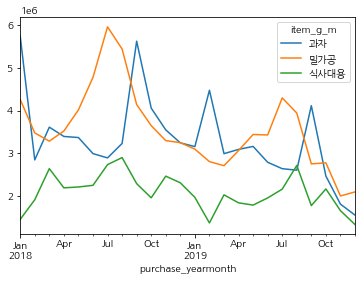

In [37]:
d_m_graph_간식 = d_m_pivot[["과자","떡","밀가공","빵","식사대용",'잼/병조림/기타']]

d_m_graph_간식_top3 = d_m_pivot[["과자","밀가공","식사대용"]]

d_m_graph_간식_top3.plot()
# "과자","떡","밀가공","빵","식사대용",'잼/병조림/기타'
#df_memsales=d_check.drop([], axis=1, inplace=False)

#df_memsales.head()

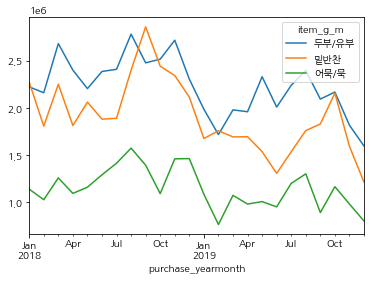

In [38]:
d_m_graph_반찬 = d_m_pivot[["김치","두부/유부","밑반찬","어묵/묵","절임/장아찌",'즉석조리']]

d_m_graph_반찬_top3 = d_m_pivot[["두부/유부","밑반찬","어묵/묵"]]

d_m_graph_반찬_top3.plot()

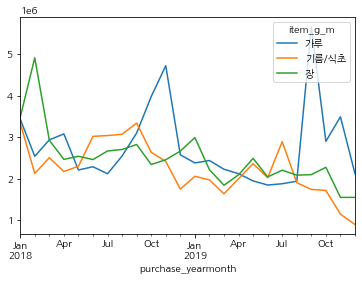

In [39]:
d_m_graph_양념_가루 = d_m_pivot[["가루","기름/식초","소금","소스/기타양념","장"]]

d_m_graph_양념_top3 = d_m_pivot[["가루","기름/식초","장"]]

d_m_graph_양념_top3.plot()

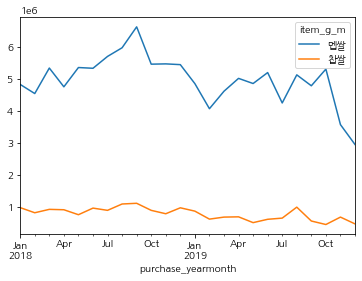

In [40]:
d_m_graph_주곡 = d_m_pivot[["멥쌀","찹쌀"]]

d_m_graph_주곡.plot()

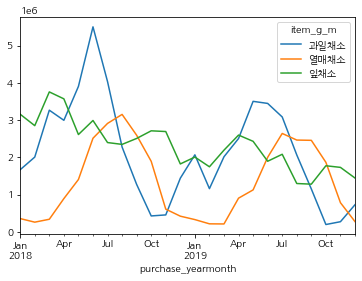

In [41]:
d_m_graph_채소 = d_m_pivot[["과일채소","김장채소","말린나물/건재","버섯","뿌리채소",'쌈채소류','양념채소','열매채소','잎/줄기채소','잎채소','특용작물']]

d_m_graph_채소_top3 = d_m_pivot[["과일채소","열매채소",'잎채소']]

d_m_graph_채소_top3.plot()

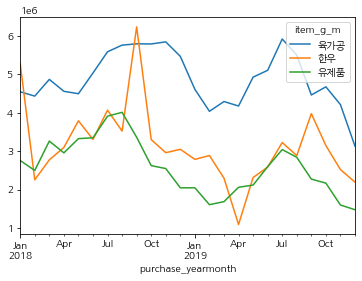

In [42]:
d_m_graph_축산물 = d_m_pivot[["꿀","닭","돼지","오리","유정란",'유제품','육가공','한우']]

d_m_graph_축산물_top3 = d_m_pivot[["육가공",'한우','유제품']]

d_m_graph_축산물_top3.plot()

### 연관규칙

#### 40대 여성 분기별 선호 제품

In [43]:
temp = copy.deepcopy(df_memsales)
tmp=temp[['customer_id','gender','agegroup','sigun','purchase_id','store_id',
            'purchase_yearmonth','item_g_l','item_g_m','item_name',
           'purchase_cnt','purchase_amt']]
ro = copy.deepcopy(tmp)

ro = ro[ro['gender'].notnull()]
ro = ro[(ro['gender'] == '여')]
ro = ro[ro['agegroup'].notnull()]
ro = ro[(ro['agegroup'] == '40대')]

ro.loc[(ro["purchase_yearmonth"] == '2018M01') \
         | (ro["purchase_yearmonth"] == '2018M02')\
         | (ro["purchase_yearmonth"] == '2018M03'), "bungi"] = "201801"
ro.loc[(ro["purchase_yearmonth"] == '2018M04') \
          | (ro["purchase_yearmonth"] == '2018M05')\
          | (ro["purchase_yearmonth"] == '2018M06'), "bungi"] = '201802'
ro.loc[(ro["purchase_yearmonth"] == '2018M07') \
          | (ro["purchase_yearmonth"] == '2018M08')\
          | (ro["purchase_yearmonth"] == '2018M09'), "bungi"] = '201803'
ro.loc[(ro["purchase_yearmonth"] == '2018M10') \
          | (ro["purchase_yearmonth"] == '2018M11')\
          | (ro["purchase_yearmonth"] == '2018M12'), "bungi"] = '201804'
ro.loc[(ro["purchase_yearmonth"] == '2019M01') \
          | (ro["purchase_yearmonth"] == '2019M02')\
          | (ro["purchase_yearmonth"] == '2019M03'), "bungi"] = '201901'
ro.loc[(ro["purchase_yearmonth"] == '2019M04') \
          | (ro["purchase_yearmonth"] == '2019M05')\
          | (ro["purchase_yearmonth"] == '2019M06'), "bungi"] = '201902'
ro.loc[(ro["purchase_yearmonth"] == '2019M07') \
          | (ro["purchase_yearmonth"] == '2019M08')\
          | (ro["purchase_yearmonth"] == '2019M09'), "bungi"] = '201903'
ro.loc[(ro["purchase_yearmonth"] == '2019M10') \
          | (ro["purchase_yearmonth"] == '2019M11')\
          | (ro["purchase_yearmonth"] == '2019M12'), "bungi"] = '201904'

# 연관 규칙
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

res = copy.deepcopy(ro)
tmp = res['bungi'] == '201804' #월 변경 지점
res = res[tmp]
# tmp = res['store_id'] == '제주매장' #월 변경 지점
# res = res[tmp]
res = res[['purchase_id','item_g_l']]


# 연관규칙 시작
ch = ( res.groupby(['purchase_id'],as_index=False)
           .agg(set))

#ch 확인
ch

enc = TransactionEncoder()
df_enc = enc.fit_transform(X = ch['item_g_l'])

asso = pd.DataFrame(df_enc, columns = enc.columns_)
#asso.head()

v_min_sup = 0.2
freq = apriori(asso, min_support=v_min_sup, use_colnames = True)
#freq 확인
freq.round(3)

asso_rule = association_rules(freq, metric = "confidence", min_threshold = 0.5)
asso_rule.round(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(반찬),(간식),0.481,0.586,0.294,0.611,1.042,0.012,1.064
1,(간식),(반찬),0.586,0.481,0.294,0.501,1.042,0.012,1.041
2,(간식),(채소),0.586,0.510,0.297,0.506,0.993,-0.002,0.992
3,(채소),(간식),0.510,0.586,0.297,0.582,0.993,-0.002,0.990
4,(간식),(축산물),0.586,0.509,0.309,0.528,1.037,0.011,1.040
5,(축산물),(간식),0.509,0.586,0.309,0.608,1.037,0.011,1.055
6,(반찬),(채소),0.481,0.510,0.295,0.614,1.205,0.050,1.271
7,(채소),(반찬),0.510,0.481,0.295,0.579,1.205,0.050,1.234
8,(반찬),(축산물),0.481,0.509,0.274,0.570,1.121,0.030,1.143
9,(축산물),(반찬),0.509,0.481,0.274,0.539,1.121,0.030,1.126
